In [16]:
# This is a sample Python script.

# Press ⌃R to execute it or replace it with your code.
# Press Double ⇧ to search everywhere for classes, files, tool windows, actions, and settings.
#Import pandas
import pandas as pd
import time
import re
import string
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import wordnet
from collections import Counter

#Instantiate Stemmer
stemmer = PorterStemmer()
def word_stemmer(text):
    stem_text = [stemmer.stem(i) for i in text]
    return stem_text
def get_part_of_speech(word):
    probable_part_of_speech = wordnet.synsets(word)
    pos_counts = Counter()
    pos_counts["n"] = len([item for item in probable_part_of_speech if item.pos() == "n"])
    pos_counts["v"] = len([item for item in probable_part_of_speech if item.pos() == "v"])
    pos_counts["a"] = len([item for item in probable_part_of_speech if item.pos() == "a"])
    pos_counts["r"] = len([item for item in probable_part_of_speech if item.pos() == "r"])

    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i, get_part_of_speech(i)) for i in text]
    return lem_text

def removeNumber(text):
    return' '.join(re.sub(r'[0-9]',' ', text).split())
def deEmojify(text):
    return text.encode('ascii', 'ignore').decode('ascii')
#TODO: remove punctutiton after stop words!!!  all the apps or none , another list: smart - nltk
stpwrd = nltk.corpus.stopwords.words('english')
new_stopwords = ["people", "app"]
stpwrd.extend(new_stopwords)
def remove_stopwords(text):
    stpwrd = nltk.corpus.stopwords.words('english')
    text = text.split(" ")
    words = [w for w in text if w not in stpwrd]
    return ' '.join(words)
def removePunctuation(text):
    no_punc = "".join([c for c in text if c not in string.punctuation])
    return no_punc
def removeLink(text):
    no_link = ' '.join(re.sub("(w+://S+)", " ", text).split())
    return no_link
def preprocess(content): #res -> clean_content
    clean_content = content.lower()
    # removeLinks
    clean_content = removeLink(clean_content)
    # remove stop words
    clean_content = remove_stopwords(clean_content)
    # removePunc
    clean_content = removePunctuation(clean_content)
    # removeEmojis
    clean_content = deEmojify(clean_content)
    # removeNumber
    clean_content = removeNumber(clean_content)
    # tokenizer
    tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')
    clean_content = tokenizer.tokenize(clean_content)
    # lemmatizer
    clean_content = word_lemmatizer(clean_content)
    # stemmer
    #clean_content = word_stemmer(clean_content)
    return clean_content
def prepare_data(dataset):
#prepare_data(df, stemmer='lan', spellcheck=False):
    start_time = time.time()
    dataset['clean_content'] = [preprocess(x) for x in dataset['content']]
    #if spellcheck: df.to_csv("/Users/neel/Desktop/bigsample_spellchecked.csv")
    print("--- %s seconds ---" % (time.time() - start_time))
    return dataset
def get_data(file):
    data = pd.read_csv(file)
    print(data.shape)
    return data

In [17]:
file = "final_annotations.csv"
# prepare the data
print("preprocessing data...")
dataset = prepare_data(get_data(file))
print("done preprocessing data...")
print(len(dataset))


preprocessing data...
(3097, 16)
--- 2.5144870281219482 seconds ---
done preprocessing data...
3097


In [18]:
df = dataset.query("aacat1 not in ['Noise', 'none']")
#df['aacat1'].unique()
corpus_list = df['clean_content'].tolist()
#corpus_list

In [19]:
#For Apriori algorithm, this dataset needs to be one-hot encoded.
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(corpus_list).transform(corpus_list)
corpus_df = pd.DataFrame(te_ary, columns=te.columns_)
corpus_df

,a,aa,aap,ab,abbreviate,ability,able,ableism,ableist,aboslutely,...,yu,zac,zayanbutt,zero,zindabad,zone,zoom,zoomyesterday,zuck,zuckerberg
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1918,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1919,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1920,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
from mlxtend.frequent_patterns import fpgrowth
start_time = time.time()
frequent_itemsets = fpgrowth(corpus_df, min_support=0.003, use_colnames=True)
print("---Runtime FP Growth: %s seconds ---" % (time.time() - start_time))
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
print("the number of frequent itemsets generated by FP Growth:", len(frequent_itemsets))

---Runtime FP Growth: 1.189357042312622 seconds ---
the number of frequent itemsets generated by FP Growth: 15746


In [21]:
frequent_itemsets.head()

,support,itemsets,length
0,0.083247,(im),1
1,0.075963,(go),1
2,0.068678,(need),1
3,0.026535,(comment),1
4,0.021332,(add),1


In [22]:
from mlxtend.frequent_patterns import association_rules
association_rules(fp_itemsets, metric="confidence", min_threshold=0.3)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=9)
#rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
#rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules
#display(rules)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(like, make, time)",(go),0.004162,0.075963,0.003642,0.875000,11.518836,0.003326,7.392300
1,"(like, make)","(time, go)",0.024454,0.015088,0.003642,0.148936,9.870873,0.003273,1.157271
2,"(like, time)","(make, go)",0.013528,0.020291,0.003642,0.269231,13.268245,0.003368,1.340654
3,"(like, go)","(make, time)",0.016649,0.018210,0.003642,0.218750,12.012500,0.003339,1.256691
4,"(make, time)","(like, go)",0.018210,0.016649,0.003642,0.200000,12.012500,0.003339,1.229188
...,...,...,...,...,...,...,...,...,...
12455,(buy),(vinted),0.012487,0.006764,0.003122,0.250000,36.961538,0.003037,1.324315
12456,(vinted),(sell),0.006764,0.015609,0.003122,0.461538,29.569231,0.003016,1.828155
12457,(sell),(vinted),0.015609,0.006764,0.003122,0.200000,29.569231,0.003016,1.241545
12458,(vinted),(addict),0.006764,0.039022,0.003122,0.461538,11.827692,0.002858,1.784674


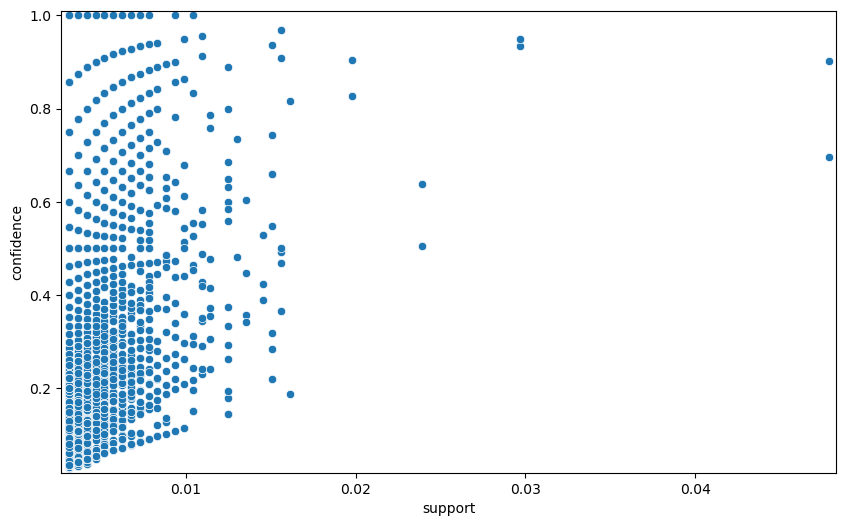

In [23]:
# Generate scatterplot using support and confidence
import matplotlib.pyplot as plt
import seaborn as sns1
plt.figure(figsize=(10,6))
sns1.scatterplot(x = "support", y = "confidence", data = rules)
plt.margins(0.01,0.01)
plt.show()

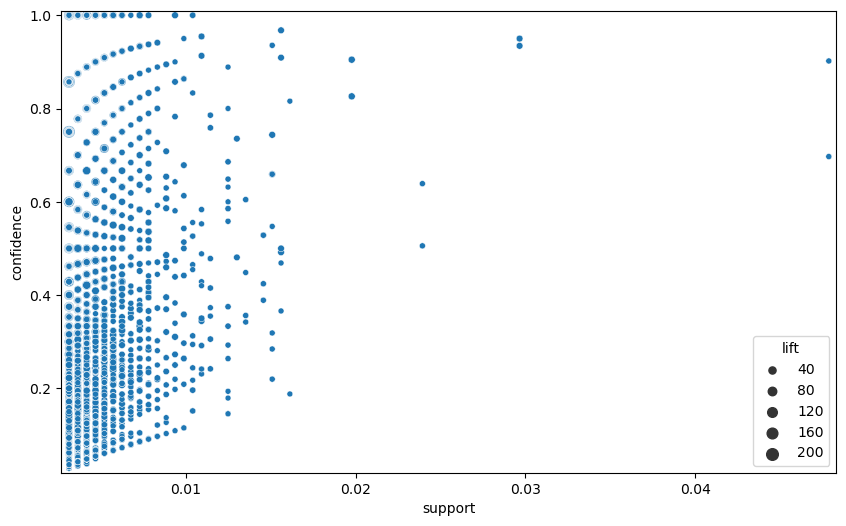

In [24]:
# Generate scatterplot using support and confidence
plt.figure(figsize=(10,6))
sns1.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.margins(0.01,0.01)
plt.show()

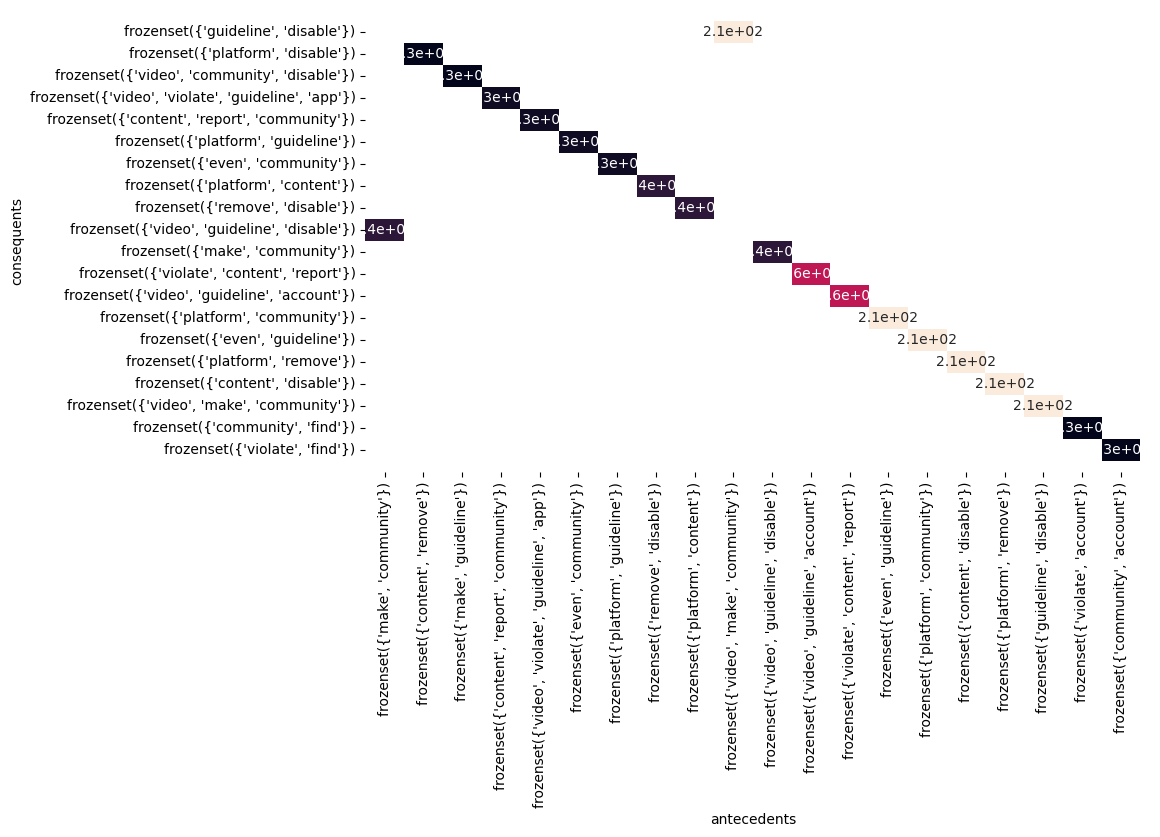

In [25]:
# Transform the DataFrame of rules into a matrix using the lift metric
import seaborn as sns1
rules_top = rules.nlargest(n = 20, columns = 'lift')

pivot = rules_top.pivot(index = 'consequents', 
                    columns = 'antecedents', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize=(10,6))
sns1.heatmap(pivot, annot = True, cbar = False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

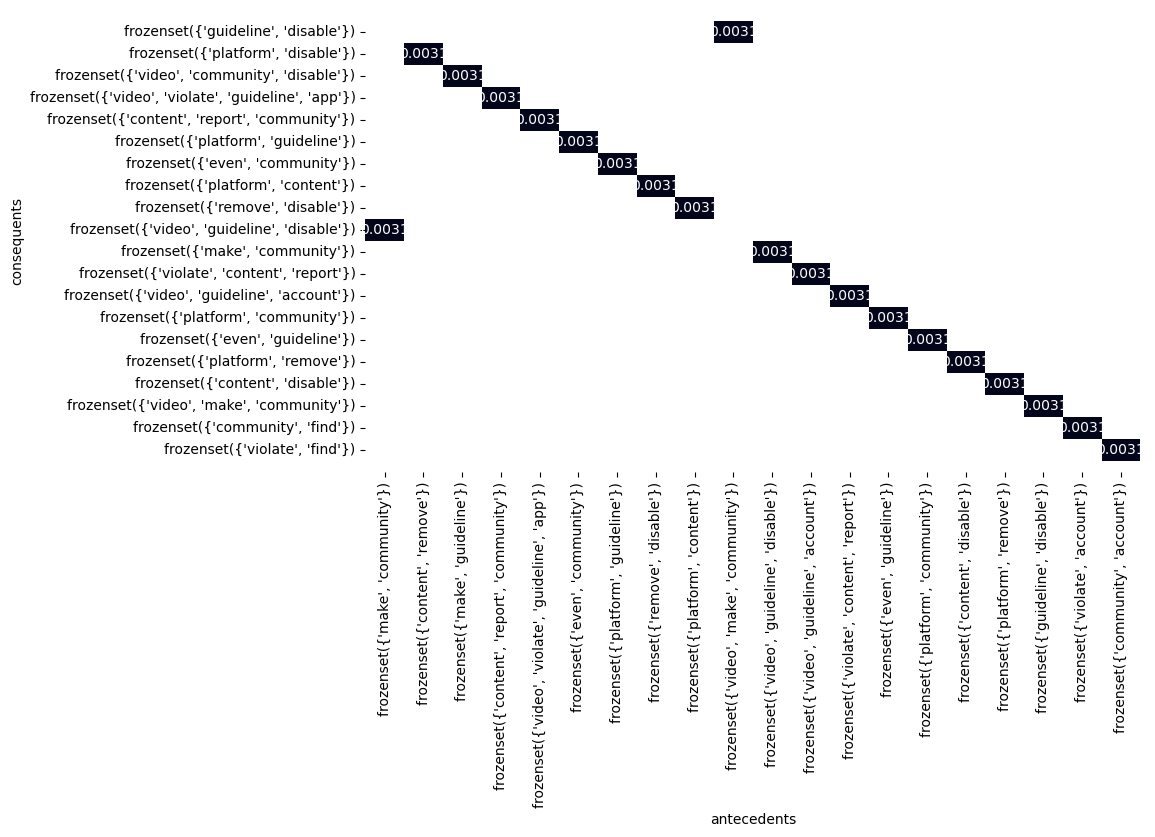

In [26]:
# Transform antecedent, consequent, and support columns into matrix
support_table = rules_top.pivot(index='consequents', columns='antecedents', values='support')

plt.figure(figsize=(10,6))
sns1.heatmap(support_table, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.show() 


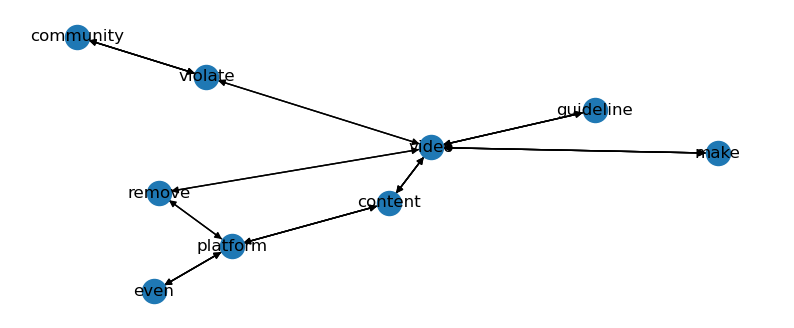

In [27]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=9)
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules_top = rules.nlargest(n = 30, columns = 'lift')

import networkx as nx
fig, ax=plt.subplots(figsize=(10,4))
GA=nx.from_pandas_edgelist(rules_top,source='antecedents',target='consequents', create_using = nx.MultiDiGraph(), edge_attr='lift')

nx.draw(GA, with_labels=True)
plt.show()
